# 08. HNSCC patient bulk RNA-seq analysis

This notebook provides the code necessary to reproduce figures pertaining to HNSCC pre-treatment RNA-seq. Data from [Uppaluri et al., 2020](https://aacrjournals.org/clincancerres/article-abstract/26/19/5140/82737/Neoadjuvant-and-Adjuvant-Pembrolizumab-in?redirectedFrom=fulltext), accessed through dbGaP (accession [phs002864](https://www.ncbi.nlm.nih.gov/projects/gap/cgi-bin/study.cgi?study_id=phs002864.v1.p1)).

In [3]:
import pandas as pd
import scanpy as sc
from anndata import AnnData
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import pandas as p
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from scipy.stats import ttest_ind
import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import fisher_exact
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu

## 0. Format raw counts and convert to AnnData object

In [4]:
# read the raw counts
counts = pd.read_csv("/path/to/HnsccPembroCohort1_counts.tsv", sep="\t", index_col=0)

# filter lowly-expressed genes
counts = counts[counts.sum(axis = 1) > 0]

# transpose
counts = counts.T

# read in metadata
metadata = pd.read_csv("/path/to/HnsccPembroCohort1_samples.tsv", sep="\t")
metadata = metadata.set_index('Patient ID')

# create separate metadata sheets for pre- and post-treatment samples
meta_pre = metadata[metadata['TIMEPOINT']=='pre']
meta_post = metadata[metadata['TIMEPOINT']=='post']
meta_pre.shape

(22, 13)

In [5]:
# filter counts matrix for only pre-treatment samples
counts_pre = counts[counts.index.isin(list(meta_pre['name']))]

In [6]:
# check for any missed samples
for i in meta_pre['name']:
    if i not in counts_pre.index:
        print(i)

In [7]:
meta_pre = meta_pre.set_index('name')

In [8]:
# initialize DESeq2 for pre-treatment samples
dds = DeseqDataSet(
    counts=counts_pre,
    metadata=meta_pre,
    design_factors="path_resp",
    ref_level=("path_resp","No")
)

dds.deseq2()

/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_60455/3305866953.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(
Fitting size factors...
... done in 0.01 seconds.

Fitting dispersions...
... done in 2.99 seconds.

Fitting dispersion trend curve...
/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/pydeseq2/dds.py:715: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 0.47 seconds.

Fitting MAP dispersions...
... done in 3.54 seconds.

Fitting LFCs...
... done in 5.57 seconds.

Calculating cook's distance...
... done in 0.04 seconds.

Replacing 2935 outlier genes.

Fitting dispersions...
... done in 0.31 seconds.

Fitting MAP dispersions...
... done in 0.36 seconds.

Fitting LFCs...
... done in 0.42 seconds.



In [9]:
dds

AnnData object with n_obs × n_vars = 22 × 39015
    obs: 'Individual', 'extraction', 'extraction_label', 'SEQUENCING', 'TIMEPOINT', 'path_stage_group', 'ENE', 'path-resp', 'maj_path_resp', 't_cell_cd8', 'neutrophil', 'total_immune'
    uns: 'mean_disp', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted'
    layers: 'normed_counts', '_mu_hat', 'cooks', 'replace_cooks'

In [10]:
# create a size-factor normalized gene expression matrix
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts_pre = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

In [11]:
# store normalized counts in an AnnData object
adata = sc.AnnData(norm_counts_pre.iloc[:, 11:])
adata.obs = meta_pre

In [12]:
# keep only RNA-seq samples
adata = adata[adata.obs['SEQUENCING']!='cDNAcap']

In [13]:
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

## 1. Plot ELF3 expression by response status

In [14]:
# define transcriptional programs
icb_res = [
    "PRSS27", "ELF3", "DESI1", "LTF", "PGLYRP4", "PDZK1IP1", "SPNS2", "PSCA", "PRSS22", "TMPRSS11G",
    "GSTO1", "KRT19", "MUC20", "TSPAN1", "DUOXA2", "TMEM242", "TMC5", "ECM1", "CBLC", "CCDC129", 
    "PRSS27P", "CAPN5", "GLRX", "SPNS3", "TMPRSS11E", "ZSCAN32", "TP53INP2", "SLC6A14", "DYNAP", 
    "DUSP4", "CLDN23", "CCDC69", "CLIC5", "GRPEL2", "APOL7B", "GDE1", "MAL", "DUOX2", "NUPR1", 
    "CLDN1", "P2RY2", "IRF7", "S100A14", "CDKN2B", "MALL", "PLEKHS1", "AC168977.1", "MUC4", "FXYD4", 
    "LY6G6D", "TRIM15", "MAL2", "WNT7B", "IFT22", "PLET1", "PPBP", "HIST1H1C", "CRYBA4", "KRT7", "HSD17B7", 
    "CLCA1", "TMPRSS11F", "SERPINB9", "CCDC186", "MYZAP", "SLC9A3R1", "PTTG1IP", "SLC28A3", "CIDEA", 
    "TMEM190", "PCDH11Y", "ARG1", "4930459C07RIK", "BSPRY", "CCDC12", "PIGR", "KRT23", "1810044K17RIK", 
    "CYP2D6", "PBP2", "CXCL5", "TMPRSS4", "LPCAT4", "CCDC71L", "ARHGAP27OS1", "EPS8L2", "TMPRSS11B", 
    "SERPINB9", "CSF3", "IFIT1", "LIPH", "EPHB3", "AA986860", "LGALS3", "RASSF7", "GRHL1", 
    "GFPT1", "TRIM16", "SPRR2D"
]

ifn_resp = [
    "GBP6", "GBP2", "IIGP1", "CNTN1", "TMEM226", "OR56A4", "MILL1", "CXCL10", "GBP4", "IFIT3", 
    "APOL10", "IFI47", "GBP5", "SLCO2A1", "PRL", "GREB1L", "GBP8", "CCL7", "TMEM121", "ZBED2", 
    "APOL9", "GPR176", "ADGRB3", "PRL", "CCL2", "RGS4", "IFIT1", "SERPINA3", "IRF1", "ASIC2", 
    "CXCL9", "MS4A4A", "IFIH1", "ZBTB8B", "ALOX12", "NRG1", "GHR", "GRIN2D", "CLIC4", "ROBO2", 
    "CCDC166", "LAMA3", "FAM126A", "ERLIN2", "GNB4", "AMMECR1", "ZC3H12C", "PRL", "SAMD5", 
    "FCGBP", "PLCB1", "FLNB", "CYP7B1", "IL24", "ALOX15", "IFIT3", "NCAM1", "CSPR2", "CD44", 
    "IL18R1", "SERPINB2", "EFEMP1", "TENM1", "CCL8", "SLC6A4", "HAS2", "UBD", "NPPB", "CCL11", 
    "FAP", "PCDH7", "IGFN1", "IFI16", "TNC", "MAJIN", "CSMD1", "ROBO1", "VCAM1", "IRF7", 
    "ZC3H12A", "NPAS3", "ITGB6", "DCLK1", "NEK10", "LY75", "CFAP47", "SLC4A7", "VEGFC", 
    "CNGA1", "HCN1", "SYT1", "SLCO1A2", "GDNF", "TENM3", "ERC1", "SKINT3", "PDLIM1", 
    "DNAH8", "CSNK1G3", "TNIP3"
]

ELF3 = ['ELF3']

In [15]:
# score each sample for each geneset
sc.tl.score_genes(adata, icb_res, score_name='icb_res')
sc.tl.score_genes(adata, ifn_resp, score_name='ifn_resp')
sc.tl.score_genes(adata, ELF3, score_name='ELF3')

       '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')
       'ADGRB3', 'CSPR2', 'MAJIN', 'CFAP47', 'SKINT3'],
      dtype='object')


/usr/local/Caskroom/mambaforge/base/envs/scrna/lib/python3.12/site-packages/scanpy/tools/_score_genes.py:176: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[score_name] = pd.Series(


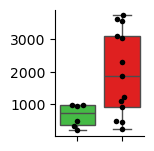

In [24]:
# plot ELF3 expression score

# extract ELF3 expression from adata.X and store in adata.obs
elf3_expr = adata.X[:, adata.var_names.get_loc('ELF3')]
elf3_expr = elf3_expr.toarray().flatten() if hasattr(elf3_expr, "toarray") else elf3_expr
adata.obs['ELF3_expr'] = elf3_expr

# define groups for comparison
group1 = adata.obs[adata.obs['path_resp'] == 'Yes']['ELF3_expr']
group2 = adata.obs[adata.obs['path_resp'] == 'No']['ELF3_expr']


# create plot
plt.figure(figsize=(2, 2))
ax = sns.boxplot(x='path_resp', y='ELF3_expr', data=adata.obs, order=condition_order, palette=treatment_palette, fliersize = 0)
sns.swarmplot(x='path_resp', y='ELF3_expr', data=adata.obs, color="black", size=4)
plt.xticks(np.arange(len(custom_labels)), custom_labels)

# set axis preferences
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.xlabel('')
plt.ylabel('')
plt.xticks(np.arange(len(custom_labels)), [''] * len(custom_labels)) 
plt.savefig('ELF3_pathresp.png', dpi = 600)
plt.show()

In [22]:
# perform t test
stat, p_val = ttest_ind(group1, group2, equal_var=False)
print(stat)
print(p_val)

-3.3528341841252303
0.0043050360030864425


## 2. Plot CD8 T cell vs. ELF3 expression score

In [21]:
# read in raw counts
counts = pd.read_csv("/path/to/HnsccPembroCohort1_counts.tsv", sep="\t", index_col=0)

# read in metadata
metadata = pd.read_csv("/path/to/HnsccPembroCohort1_samples.tsv", sep="\t")

# ensure sample names match the counts matrix column names
metadata = metadata.set_index("name")  # 'name' column matches column names in counts

# reorder metadata to match the order of columns in the counts matrix
metadata = metadata.loc[counts.columns]

# convert to AnnData object
adata = AnnData(X=counts.T, obs=metadata)


In [22]:
adata.var_names = counts.index

In [23]:
adata = adata[adata.obs['SEQUENCING']!='cDNAcap']

In [24]:
# extract counts and metadata
counts_df = pd.DataFrame(adata.X.T, index=adata.var_names, columns=adata.obs_names).astype(int)
col_data = adata.obs.copy()

# transpose counts
counts_df_T = counts_df.T

# re-index metadata to match counts
metadata = metadata.reindex(counts_df_T.index)

# set condition for design factor to pre- vs post-treatment
# this is essentially a dummy variable because we will
# not be performing differential expression analysis
metadata["condition"] = metadata["TIMEPOINT"]

# initialize DESeq2
dds = DeseqDataSet(
    counts=counts_df_T,
    metadata=metadata,
    design_factors="condition",
    ref_level=("condition", "pre")  
)

dds.deseq2()

Fitting size factors...
... done in 0.04 seconds.

Fitting dispersions...
... done in 2.82 seconds.

Fitting dispersion trend curve...
... done in 0.55 seconds.

Fitting MAP dispersions...
... done in 3.45 seconds.

Fitting LFCs...
... done in 2.03 seconds.

Calculating cook's distance...
... done in 0.06 seconds.

Replacing 2386 outlier genes.

Fitting dispersions...
... done in 0.22 seconds.

Fitting MAP dispersions...
... done in 0.23 seconds.

Fitting LFCs...
... done in 0.17 seconds.



In [25]:
# create normalized counts matrix
dds_obs_df = pd.DataFrame(dds.obs)
dds_var_df = pd.DataFrame(dds.var)
dds_matrix_df = pd.DataFrame(dds.layers['normed_counts'], index=dds.obs.index, columns=dds.var.index)

norm_counts = pd.concat([dds_obs_df, dds_matrix_df], axis=1)

In [26]:
# make sure gene order is preserved
assert all(adata.var_names == dds_matrix_df.columns), "Gene order mismatch!"

In [27]:
# add normalized counts as new layer to adata
adata.layers["norm_counts"] = dds_matrix_df.loc[adata.obs_names, adata.var_names].values


/var/folders/5n/z6n7v0d52cz96tmj0j15w_g80000gn/T/ipykernel_57495/1265695218.py:2: ImplicitModificationWarning: Setting element `.layers['norm_counts']` of view, initializing view as actual.
  adata.layers["norm_counts"] = dds_matrix_df.loc[adata.obs_names, adata.var_names].values


In [28]:
# score ELF3 and ICB-resistance program expression
sc.tl.score_genes(adata, icb_res, score_name='icb_res')
sc.tl.score_genes(adata, ELF3, score_name='ELF3_score')

       '1810044K17RIK', 'PBP2', 'ARHGAP27OS1', 'AA986860'],
      dtype='object')


Optimal Elf3 cut = -919.6
Optimal CD8 cut = 0.13


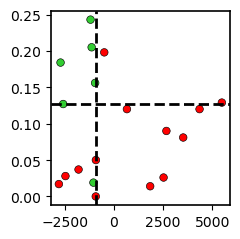

Fisher exact p = 0.000516,   odds ratio = inf


In [29]:
# subset adata to only pre-treatment samples
pre = adata.obs[adata.obs["TIMEPOINT"] == "pre"].copy()

# calculate optimal cutoffs for response prediction

# find ELF3 cutoff that maximizes tpr - fpr (i.e. Younen index) for non-response
y_nonresp = (pre["path_resp"] == "No").astype(int)
fpr, tpr, thr = roc_curve(y_nonresp, pre["ELF3_score"])
ELF3_HIGH_CUT = thr[np.argmax(tpr - fpr)]

# find CD8 score cutoff that maximizes Younen index for response
y_resp = (pre["path_resp"] == "Yes").astype(int)
fpr_i, tpr_i, thr_i = roc_curve(y_resp, pre["t_cell_cd8"])
IMMUNE_HOT_CUT = thr_i[np.argmax(tpr_i - fpr_i)]

print(f"Optimal Elf3 cut = {ELF3_HIGH_CUT:0.1f}")
print(f"Optimal CD8 cut = {IMMUNE_HOT_CUT:0.2f}")

# annotate data with cutoffs
pre["Elf3_high"]   = pre["ELF3_score"]   >= ELF3_HIGH_CUT
pre["Immune_hot"]  = pre["t_cell_cd8"] >= IMMUNE_HOT_CUT

def decision(entry):
    if entry.Elf3_high:      return "Predicted Non‑resp"
    if entry.Immune_hot:     return "Predicted Resp"
    return "Predicted Non‑resp"

pre["response_call"] = pre.apply(decision, axis=1)

# plot CD8 and ELF3 scores with response status

plt.figure(figsize=(2.5, 2.5))
palette = {"Yes": "limegreen", "No": "red"}

sns.scatterplot(data=pre,
                x="ELF3_score", y="t_cell_cd8",
                hue="path_resp",
                palette=palette,
                markers="o",
                edgecolor="black", s=30)

# define quadrants by cutoffs
plt.axvline(ELF3_HIGH_CUT, ls="--", lw=2, color='black')
plt.axhline(IMMUNE_HOT_CUT, ls="--", lw=2, color='black')

# format plot
plt.xlabel("")
plt.ylabel("")
plt.title("")

ax = plt.gca()  
for spine in ax.spines.values():
    spine.set_edgecolor("black")
    spine.set_linewidth(1.2) 
plt.tight_layout()
plt.legend([],[], frameon=False)

plt.show()

# perform statistical testing
ct = pd.crosstab(pre["response_call"], pre["path_resp"])
odds, p = fisher_exact(ct)
print(f"Fisher exact p = {p:0.3g},   odds ratio = {odds:0.2f}")

## 3. Plot Neutrophil and CD8 T cell cytotoxicity signatures

In [30]:
# define signatures
n2_neutrophil_signature = [
  "ARG1","CXCL8","VEGFA","IL1RN","S100A9","CEACAM1","ANXA1","SLPI","MPO"
]

cd8_cytotoxic_signature = [
  "GZMB","GZMA","PRF1","GNLY","IFNG","CD8A","CD8B","PDCD1","TOX","IL2",
    "CD69","CTLA4","TIGIT"
]

In [31]:
# define function for simple gene expression scoring
def score_signature(
    adata, 
    gene_list, 
    score_name="signature_score", 
    layer="norm_counts", 
    groupby="path_resp", 
    figsize=(4, 4), 
    savefig=False
):

    valid_genes = [g for g in gene_list if g in adata.var_names]
    if not valid_genes:
        raise ValueError("gene name error")

    # score by mean expression
    score_matrix = adata[:, valid_genes].layers[layer]
    adata.obs[score_name] = score_matrix.mean(axis=1)

In [32]:
score_signature(
    adata,
    gene_list=n2_neutrophil_signature,
    score_name="n2_neutrophil_signature",
    layer="norm_counts"
)

score_signature(
    adata,
    gene_list=ELF3,
    score_name="ELF3_score",
    layer="norm_counts"
)

score_signature(
    adata,
    gene_list=cd8_cytotoxic_signature,
    score_name="cd8_cytotoxic_signature",
    layer="norm_counts"
)

score_signature(
    adata,
    gene_list=icb_res,
    score_name="icb_res_score",
    layer="norm_counts"
)

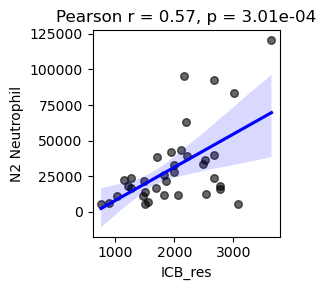

In [33]:
# plot N2 neutrophil signature as a function of ICB-resistance score

# extract data from adata
x = adata.obs["icb_res_score"]
y = adata.obs["n2_neutrophil_signature"]

# pearson correlation
r, pval = pearsonr(x, y)

# plot
plt.figure(figsize=(3, 3))
sns.regplot(
    x=x, y=y,
    scatter_kws={"s": 30, "alpha": 0.6, "color": "black"},
    line_kws={"color": "blue"}
)

# format plot
plt.grid(False)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.tick_params(axis='both', colors='black')
plt.xlabel("ICB_res", color='black')
plt.ylabel("N2 Neutrophil", color='black')
plt.title(f"Pearson r = {r:.2f}, p = {pval:.2e}", color='black')

plt.tight_layout()

plt.show()

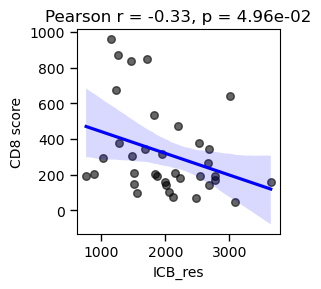

In [34]:
# plot CD8 cytotoxicity score as a function of ICB-resistance signature
x = adata.obs["icb_res_score"]
y = adata.obs["cd8_cytotoxic_signature"]

# pearson correlation
r, pval = pearsonr(x, y)

# plot
plt.figure(figsize=(3, 3))
sns.regplot(
    x=x, y=y,
    scatter_kws={"s": 30, "alpha": 0.6, "color": "black"},
    line_kws={"color": "blue"}
)

# format plot
plt.grid(False)
plt.gca().spines['top'].set_color('black')
plt.gca().spines['right'].set_color('black')
plt.gca().spines['bottom'].set_color('black')
plt.gca().spines['left'].set_color('black')
plt.tick_params(axis='both', colors='black')
plt.xlabel("ICB_res", color='black')
plt.ylabel("CD8 score", color='black')
plt.title(f"Pearson r = {r:.2f}, p = {pval:.2e}", color='black')
ax = plt.gca()

ax.tick_params(
    axis="both",          # x and y
    which="both",         # major and minor ticks
    direction="out",      # point outward
    length=5,             # 5‑pt long ticks  (adjust to taste)
    width=1,              # line width
    colors="black"        # tick colour
)
plt.tight_layout()

plt.show()